
There are 2 stages to this experiment. First is to bucket the dataset and second is to train based on entropy score. 
Bucketing the dataset involves the following:
1. using ``google-bert/bert-base-uncased``, we will tokenize the text.
2. On default, ``bert-base-uncased`` creates embeddings that are in 768 dimensions.
3. Embeddings are then reduced in size to around 50.
4. Extract n amount from each bucket to create the first training stage dataset.

Training based on entropy score involves the following:
1. Remove the previously trained data from the dataset pool.
2. Predict on the rest of the dataset pool using the previously trained data in stage 1.
3. Convert prediction scores to entropy
4. Sort by highest entropy, seperate into buckets again.
5. Extract m amount from each bucket to create the second training stage dataset.
  
Entropy based training can be done multiple times until sufficient.

For each stage, we can compare it to a model trained on a randomly selected amount of data from the dataset pool. 

Since we are trying to prove that it is possible to create a high quality model without a huge amount of data, for each comparison, we can select the same amount of data used to train the bucketing model up to that point.

# Load and preprocess dataset
We are trying to prove that bucketing and entropy based training can reduce the amount of data needed to reduce a well balanced model. This is a case of one-shot model training. To reduce external factors such as bad data quality, etc; we will be utilizing StanfordNLP's SST2 dataset which  is a standard NLP benchmark for sentiment classification. The dataset will be loaded from huggingface via ``stanfordnlp/sst2``

In [18]:
import re
def clean_text(row):
    text = row["text"]
    # Remove HTML tags
    text = re.sub(r"<.*?>", " ", text)
    # Remove non-printable characters
    text = re.sub(r"[\x00-\x1F\x7F]", " ", text)
    # Replace multiple spaces/newlines with single space
    text = re.sub(r"\s+", " ", text)
    text = text.lower()
    # Optionally lowercase
    text = text.strip()  # Don't lowercase if case matter
    return {
        "text": text
    }

In [19]:
from datasets import load_dataset
import test

def process_initial_dataset():
  ds = load_dataset("mteb/amazon_polarity", cache_dir="caches/")
  train_ds = ds["train"]
  test_ds = ds["test"]
  
  train_valid = train_ds.train_test_split(test_size=0.01, seed=42)
  test_valid = test_ds.train_test_split(test_size=0.01, seed=42)

  train_ds_reduced = train_valid["test"]
  test_ds_reduced = test_valid["test"]

  train_ds_reduced = train_ds_reduced.map(clean_text)
  test_ds_reduced = test_ds_reduced.map(clean_text)

  print(f"Train DS length: {len(train_ds_reduced)}")
  print(f"Test DS length: {len(test_ds_reduced)}")
  return train_ds_reduced, test_ds_reduced
  

In [20]:
train_ds_reduced, test_ds_reduced = process_initial_dataset()

Train DS length: 36000
Test DS length: 4000


In [4]:
train_ds_reduced[0]

{'label': 0,
 'text': "amazon should apologize for kindle delays over christmas!!! with all the hype about ordering kindle for the holidays i ordered early - in november, figuring i'd give it a shot despite the high price and semi-negative feedback. so, imagine my dismay with a week to go before christmas - and not only has the thing never shipped - i now get a little cheerful snowflake-clad announcement that it won't even arrive until after christmas! a month after i ordered it! maybe amazon shouldn't be hyping their products if they can't build enough of them to deliver for the holidays. maybe they should put their current ads on hiatus until they can at least fill their back orders. i am very disappointed. at this cost point, had i known that the product would not reach me by the holidays, i would have simply purchased something else.shame on you, amazon!",
 'label_text': 'negative'}

In [8]:
def get_global_label_count(dataset):
  negative_dataset = dataset.filter(lambda x: x["label"] == 0)
  positive_dataset = dataset.filter(lambda x: x["label"] == 1)
  
  negative_count = len(negative_dataset)
  positive_count = len(positive_dataset)
  
  return negative_count, positive_count

In [6]:
print(get_global_label_count(train_ds_reduced))

(17911, 18089)


In [21]:
small_sample = train_ds_reduced.shuffle(seed=42).select(range(200))
negative_count, positive_count = get_global_label_count(small_sample)
negative_percentage = (negative_count / len(small_sample)) * 100
positive_percentage = (positive_count / len(small_sample)) * 100
print(f"Negative: {negative_count} ({negative_percentage:.2f}%)")
print(f"Positive: {positive_count} ({positive_percentage:.2f}%)")

Negative: 110 (55.00%)
Positive: 90 (45.00%)


# Generate embeddings
As mentioned before, embeddings are generated using ```google-bert/bert-base-uncased``` model. 

Define the tokenizer function

In [17]:
import torch
from transformers import AutoTokenizer, AutoModel

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

model = AutoModel.from_pretrained("google-bert/bert-base-uncased", cache_dir="caches/")
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased", cache_dir="caches/")
model.to(device)
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [18]:
import torch
def get_mean_pooled_embeddings(batch):
  inputs = tokenizer(
    batch["text"],
    truncation=True,
    padding="max_length",
    return_tensors="pt"
  )
  inputs = {k: v.to(device) for k, v in inputs.items()}
  with torch.no_grad():
    outputs = model(**inputs)
  last_hidden = outputs.last_hidden_state
  mask = inputs["attention_mask"].unsqueeze(-1)
  mean_pool = (last_hidden * mask).sum(dim = 1) / mask.sum(dim = 1)
  return {
    "mean_pooled_embeddings": mean_pool.cpu().numpy()
  }
  

In [19]:
train_ds_reduced = train_ds_reduced.map(get_mean_pooled_embeddings, batch_size=8, batched=True)

Map: 100%|██████████| 25000/25000 [23:50<00:00, 17.48 examples/s]


In [21]:
import numpy as np
np.save("imdb_embeddings.npy", train_ds_reduced["mean_pooled_embeddings"])

In [22]:
import numpy as np
mean_pooled_bert_embeddings = np.load("bert_mean_pooled_embeddings.npy")

In [10]:
import numpy as np
mean_pooled_bert_embeddings = np.load("imdb_embeddings.npy")

# Create clusters

So i tried a few different experiments where i either:
1. reduce 768 dimensions to 50
2. reduce 768 dimensiosn to 2
3. reduce 768 dimensions to 50 to 50
4. reduce 768 dimensions to 50 to 2
5. reduce 768 dimensions to 2 to 2


Lets compare the scores

In [11]:
from umap import UMAP
from sklearn.preprocessing import RobustScaler
from hdbscan import HDBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

scaler = RobustScaler()
label_umap = UMAP(n_components=50, random_state=42)
visual_umap = UMAP(n_components=2, random_state=42)
clusterer = HDBSCAN(min_cluster_size=200)

In [ ]:

# 768 -> 50

label_embeddings = label_umap.fit_transform(mean_pooled_bert_embeddings)
# label_embeddings = visual_umap.fit_transform(label_embeddings)
label_embeddings = scaler.fit_transform(label_embeddings)

labels = clusterer.fit_predict(label_embeddings)

mask = labels != -1
filtered_embeddings = label_embeddings[mask]
filtered_labels = labels[mask]

if len(np.unique(filtered_labels)) > 1:  # At least 2 clusters needed for metrics
    sil_score = silhouette_score(filtered_embeddings, filtered_labels)
    db_score = davies_bouldin_score(filtered_embeddings, filtered_labels)
    ch_score = calinski_harabasz_score(filtered_embeddings, filtered_labels)
    n_clusters = len(np.unique(filtered_labels))
else:
    sil_score = db_score = ch_score = np.nan
    n_clusters = len(np.unique(filtered_labels))

print(f"clusters={n_clusters} | Silhouette: {sil_score:.4f} | Davies-Bouldin: {db_score:.4f} | Calinski-Harabasz: {ch_score:.4f}")

# 768 -> 2

label_embeddings = visual_umap.fit_transform(mean_pooled_bert_embeddings)
# label_embeddings = visual_umap.fit_transform(label_embeddings)
label_embeddings = scaler.fit_transform(label_embeddings)

labels = clusterer.fit_predict(label_embeddings)

mask = labels != -1
filtered_embeddings = label_embeddings[mask]
filtered_labels = labels[mask]

if len(np.unique(filtered_labels)) > 1:  # At least 2 clusters needed for metrics
    sil_score = silhouette_score(filtered_embeddings, filtered_labels)
    db_score = davies_bouldin_score(filtered_embeddings, filtered_labels)
    ch_score = calinski_harabasz_score(filtered_embeddings, filtered_labels)
    n_clusters = len(np.unique(filtered_labels))
else:
    sil_score = db_score = ch_score = np.nan
    n_clusters = len(np.unique(filtered_labels))

print(f"clusters={n_clusters} | Silhouette: {sil_score:.4f} | Davies-Bouldin: {db_score:.4f} | Calinski-Harabasz: {ch_score:.4f}")


# 768 -> 50 -> 50

label_embeddings = label_umap.fit_transform(mean_pooled_bert_embeddings)
label_embeddings = label_umap.fit_transform(label_embeddings)
label_embeddings = scaler.fit_transform(label_embeddings)

labels = clusterer.fit_predict(label_embeddings)

mask = labels != -1
filtered_embeddings = label_embeddings[mask]
filtered_labels = labels[mask]

if len(np.unique(filtered_labels)) > 1:  # At least 2 clusters needed for metrics
    sil_score = silhouette_score(filtered_embeddings, filtered_labels)
    db_score = davies_bouldin_score(filtered_embeddings, filtered_labels)
    ch_score = calinski_harabasz_score(filtered_embeddings, filtered_labels)
    n_clusters = len(np.unique(filtered_labels))
else:
    sil_score = db_score = ch_score = np.nan
    n_clusters = len(np.unique(filtered_labels))

print(f"clusters={n_clusters} | Silhouette: {sil_score:.4f} | Davies-Bouldin: {db_score:.4f} | Calinski-Harabasz: {ch_score:.4f}")

# 768 -> 50 -> 2

label_embeddings = label_umap.fit_transform(mean_pooled_bert_embeddings)
label_embeddings = visual_umap.fit_transform(label_embeddings)
label_embeddings = scaler.fit_transform(label_embeddings)

labels = clusterer.fit_predict(label_embeddings)

mask = labels != -1
filtered_embeddings = label_embeddings[mask]
filtered_labels = labels[mask]

if len(np.unique(filtered_labels)) > 1:  # At least 2 clusters needed for metrics
    sil_score = silhouette_score(filtered_embeddings, filtered_labels)
    db_score = davies_bouldin_score(filtered_embeddings, filtered_labels)
    ch_score = calinski_harabasz_score(filtered_embeddings, filtered_labels)
    n_clusters = len(np.unique(filtered_labels))
else:
    sil_score = db_score = ch_score = np.nan
    n_clusters = len(np.unique(filtered_labels))

print(f"clusters={n_clusters} | Silhouette: {sil_score:.4f} | Davies-Bouldin: {db_score:.4f} | Calinski-Harabasz: {ch_score:.4f}")

# 768 -> 2 -> 2

label_embeddings = visual_umap.fit_transform(mean_pooled_bert_embeddings)
label_embeddings = visual_umap.fit_transform(label_embeddings)
label_embeddings = scaler.fit_transform(label_embeddings)

labels = clusterer.fit_predict(label_embeddings)

mask = labels != -1
filtered_embeddings = label_embeddings[mask]
filtered_labels = labels[mask]

if len(np.unique(filtered_labels)) > 1:  # At least 2 clusters needed for metrics
    sil_score = silhouette_score(filtered_embeddings, filtered_labels)
    db_score = davies_bouldin_score(filtered_embeddings, filtered_labels)
    ch_score = calinski_harabasz_score(filtered_embeddings, filtered_labels)
    n_clusters = len(np.unique(filtered_labels))
else:
    sil_score = db_score = ch_score = np.nan
    n_clusters = len(np.unique(filtered_labels))

print(f"clusters={n_clusters} | Silhouette: {sil_score:.4f} | Davies-Bouldin: {db_score:.4f} | Calinski-Harabasz: {ch_score:.4f}")

/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Based on the results itself, I discovered quite a surprising result where an unorthodox feature of reducing BERT embeddings of 768 to 50 then 2 before passing it through the HDBSCAN clustering algorithm yielded the best results of all. It is very much unorthodox and contrary to popular beliefs. But since the scores are significantly better, we will be proceeding with this in the next steps/

/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


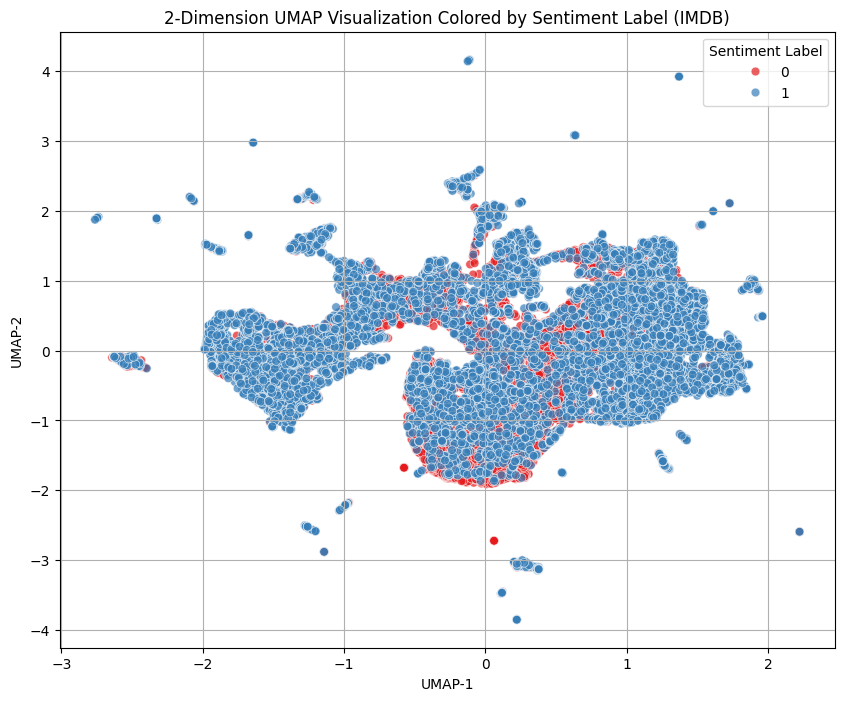

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
label_umap = UMAP(n_components=50, random_state=42)
visual_umap = UMAP(n_components=2, random_state=42)

X_umap = label_umap.fit_transform(mean_pooled_bert_embeddings)
X_umap = visual_umap.fit_transform(X_umap)
X_umap = scaler.fit_transform(X_umap)

y_true = train_ds_reduced["label"]

plt.figure(figsize=(10, 8))
palette = sns.color_palette("Set1", n_colors=len(set(y_true)))  # distinct colors for each label
sns.scatterplot(x= X_umap[:, 0], y=X_umap[:, 1], hue=y_true, palette=palette, alpha=0.7, s=40)
plt.title('2-Dimension UMAP Visualization Colored by Sentiment Label (IMDB)')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.legend(title='Sentiment Label')
plt.grid(True)
plt.show()

/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


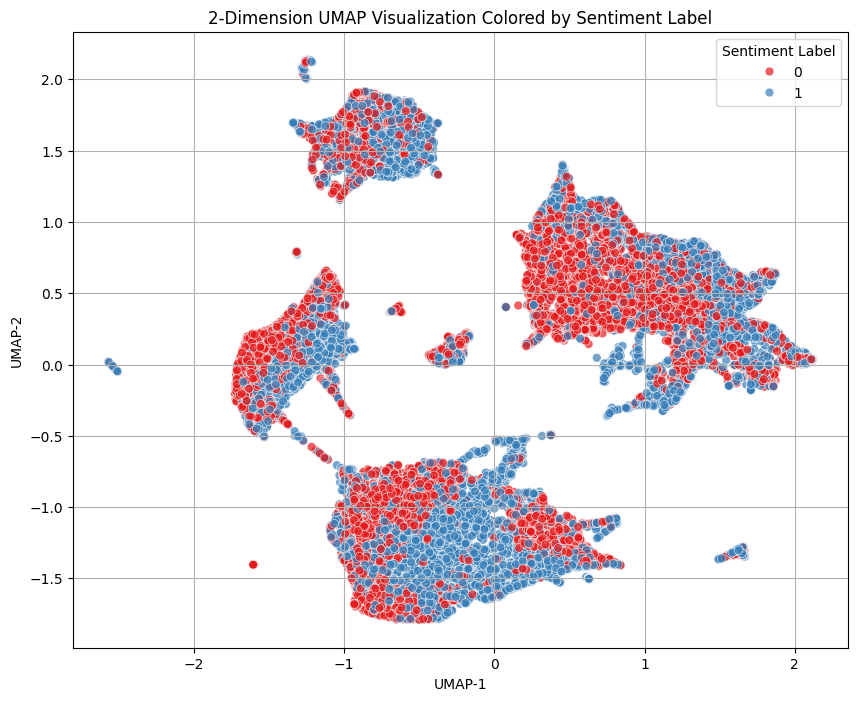

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
label_umap = UMAP(n_components=50, random_state=42)
visual_umap = UMAP(n_components=2, random_state=42)

X_umap = label_umap.fit_transform(mean_pooled_bert_embeddings)
X_umap = visual_umap.fit_transform(X_umap)
X_umap = scaler.fit_transform(X_umap)

y_true = train_ds_reduced["label"]

plt.figure(figsize=(10, 8))
palette = sns.color_palette("Set1", n_colors=len(set(y_true)))  # distinct colors for each label
sns.scatterplot(x= X_umap[:, 0], y=X_umap[:, 1], hue=y_true, palette=palette, alpha=0.7, s=40)
plt.title('2-Dimension UMAP Visualization Colored by Sentiment Label')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.legend(title='Sentiment Label')
plt.grid(True)
plt.show()

/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings

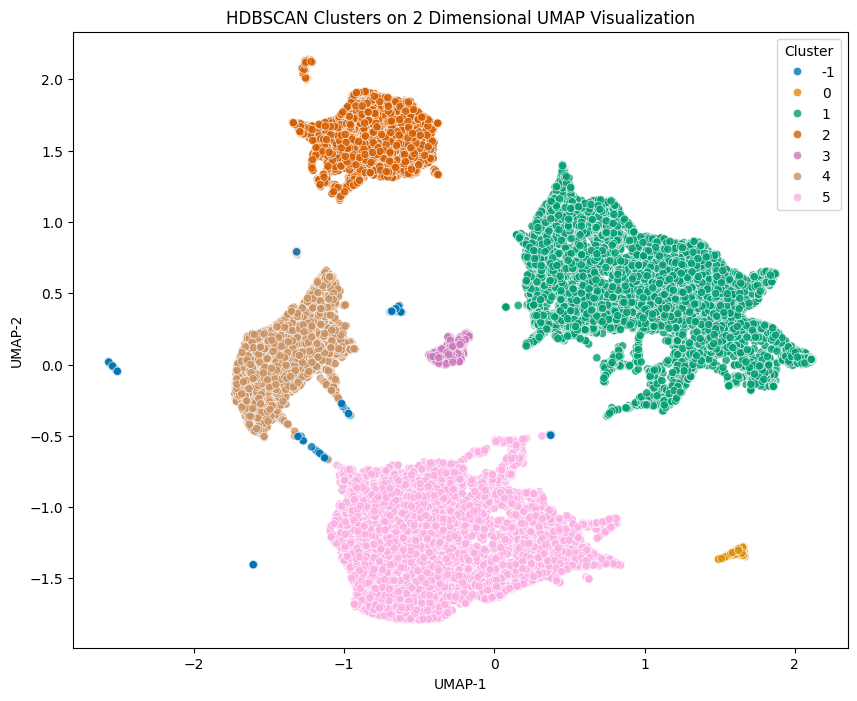

clusters=6 | Silhouette: 0.5002 | Davies-Bouldin: 0.4352 | Calinski-Harabasz: 46558.5393


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP
from sklearn.preprocessing import StandardScaler
from hdbscan import HDBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

scaler = StandardScaler()
label_umap = UMAP(n_components=50, random_state=42)
visual_umap = UMAP(n_components=2, random_state=42)
# This section is purely to alter the embedding dimensions to produce the labels
clusterer = HDBSCAN(min_cluster_size=200)

label_embeddings = label_umap.fit_transform(mean_pooled_bert_embeddings)
label_embeddings = visual_umap.fit_transform(label_embeddings)
# label_embeddings = visual_umap.fit_transform(label_embeddings)
label_embeddings = scaler.fit_transform(label_embeddings)

labels = clusterer.fit_predict(label_embeddings)

# This section is purely for visualization

X_umap = label_umap.fit_transform(mean_pooled_bert_embeddings)
X_umap = visual_umap.fit_transform(X_umap)
X_umap = scaler.fit_transform(X_umap)

# 3. Plot t-SNE results colored by HDBSCAN cluster labels
plt.figure(figsize=(10, 8))
palette = sns.color_palette("colorblind", n_colors=len(set(labels)))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=labels, palette=palette, legend='full', alpha=0.8)

plt.title("HDBSCAN Clusters on 2 Dimensional UMAP Visualization")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title='Cluster')
plt.show()

mask = labels != -1
filtered_embeddings = label_embeddings[mask]
filtered_labels = labels[mask]

if len(np.unique(filtered_labels)) > 1:  # At least 2 clusters needed for metrics
    sil_score = silhouette_score(filtered_embeddings, filtered_labels)
    db_score = davies_bouldin_score(filtered_embeddings, filtered_labels)
    ch_score = calinski_harabasz_score(filtered_embeddings, filtered_labels)
    n_clusters = len(np.unique(filtered_labels))
else:
    sil_score = db_score = ch_score = np.nan
    n_clusters = len(np.unique(filtered_labels))

print(f"clusters={n_clusters} | Silhouette: {sil_score:.4f} | Davies-Bouldin: {db_score:.4f} | Calinski-Harabasz: {ch_score:.4f}")



# Building a dataset for model training

Using the results of the previous experiment, let's redefine some program variables

In [23]:
from umap import UMAP
from sklearn.preprocessing import RobustScaler
from hdbscan import HDBSCAN
import numpy as np

scaler = RobustScaler()
umap_50 =  UMAP(n_components=50, random_state=42)
umap_2 = UMAP(n_components=2, random_state=42)
clusterer = HDBSCAN(min_cluster_size=200)


# Reduce and scale the embeddings

reduced_embedding = umap_50.fit_transform(mean_pooled_bert_embeddings)
reduced_embedding = umap_2.fit_transform(reduced_embedding)
reduced_embedding = scaler.fit_transform(reduced_embedding)


# Cluster the embeddings
labels = clusterer.fit_predict(reduced_embedding)
labels = np.array(labels)
unique_labels = np.unique(labels)
# Apply the labels on the training dataset

train_ds_reduced = train_ds_reduced.add_column("bucket", labels)

grouped_datasets = [
  train_ds_reduced.select(indices) for label in unique_labels for indices in [np.where(labels == label)[0]]
]


/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings

# Initialize models and tokenizers

In [24]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased", cache_dir="caches/")

In [25]:
#Calculate global ratios
positive_count = train_ds_reduced.filter(lambda x: x["label"] == 1).num_rows
negative_count = train_ds_reduced.filter(lambda x: x["label"] == 0).num_rows

positive_ratio = positive_count / (positive_count + negative_count)
negative_ratio = negative_count / (positive_count + negative_count)

Filter: 100%|██████████| 36000/36000 [00:00<00:00, 466702.14 examples/s]


In [26]:
def get_tokens(batch):
  tokens =  tokenizer(
    batch["text"],
    truncation=True,
    padding="max_length",
    return_tensors="pt",
    max_length=256
  )
  return tokens

Sample n amount from each bucket to create a dataset

In [27]:
from datasets import concatenate_datasets
import math

def build_dataset(dataset, total_size, positive_ratio, negative_ratio):
    total_original_size = sum(len(ds) for ds in dataset)
    merged = []
    
    for ds in dataset:
        bucket_share = len(ds) / total_original_size
        bucket_target_size = math.floor(bucket_share * total_size)
        
        positive_filtered = ds.filter(lambda x: x["label"] == 1)
        negative_filtered = ds.filter(lambda x: x["label"] == 0)
        
        max_positive = len(positive_filtered)
        max_negative = len(negative_filtered)
        
        amount_positive = min(math.floor(bucket_target_size * positive_ratio), max_positive)
        amount_negative = min(math.floor(bucket_target_size * negative_ratio), max_negative)
        
        positive_sample = positive_filtered.shuffle(seed=42).select(range(amount_positive))
        negative_sample = negative_filtered.shuffle(seed=42).select(range(amount_negative))
        
        merged.extend([positive_sample, negative_sample])
        
    final_dataset = concatenate_datasets(merged)
    final_dataset = final_dataset.map(get_tokens, batched=True, batch_size=8)
    final_dataset = final_dataset.rename_column("label", "labels")
    final_dataset = final_dataset.train_test_split(test_size=0.15, seed=42)
    return final_dataset["train"], final_dataset["test"]


# Train the model on the bucketed data

In [37]:
from gc import callbacks
from transformers import TrainingArguments

training_args = TrainingArguments(
  num_train_epochs=5,
  per_device_train_batch_size=8,
  save_strategy="epoch",
  logging_strategy="epoch",
  logging_steps=50,
  load_best_model_at_end=True,
  metric_for_best_model="eval_accuracy",
  greater_is_better=True,
  eval_strategy="epoch",
  warmup_ratio=0.1,
  weight_decay=0.01,
  learning_rate=3e-5,
  lr_scheduler_type="linear",
  dataloader_pin_memory=False
)

In [29]:
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
)
import numpy as np

def compute_metrics(eval_pred):
  logits, labels = eval_pred
  preds = np.argmax(logits, axis=-1)
  precision, recall, f1, _ = precision_recall_fscore_support(
      labels, preds, average="binary", pos_label=1, zero_division=0
  )

  acc = accuracy_score(labels, preds)

  return {
      "eval_accuracy": acc,
      "eval_precision": precision,
      "eval_recall": recall,
      "eval_f1": f1,
  }

In [30]:
test_ds_reduced = test_ds_reduced.map(get_tokens, batch_size=16, batched=True)
if "labels" not in test_ds_reduced.column_names:
    test_ds_reduced = test_ds_reduced.rename_column("label", "labels")

Map: 100%|██████████| 4000/4000 [00:00<00:00, 7034.36 examples/s]


In [31]:
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
)

CLASS_NAMES = ["negative", "positive"]  # adjust as needed
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)

    # macro metrics
    macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(
        labels, preds, average="macro", zero_division=0
    )
    acc = accuracy_score(labels, preds)

    # per-class metrics
    per_class = precision_recall_fscore_support(
        labels, preds, average=None, zero_division=0
    )
    p_cls, r_cls, f1_cls, support_cls = per_class

    metrics = {
        "accuracy": acc,
        "macro_f1": macro_f1,
        "macro_precision": macro_p,
        "macro_recall": macro_r,
    }
    for idx, name in enumerate(CLASS_NAMES):
        metrics[f"{name}_precision"] = p_cls[idx]
        metrics[f"{name}_recall"]    = r_cls[idx]
        metrics[f"{name}_f1"]        = f1_cls[idx]
        metrics[f"{name}_support"]   = support_cls[idx]

    return metrics


Perform loop checking every 1000 data

In [39]:
from transformers import Trainer, default_data_collator
from torch.optim import AdamW
import pandas as pd
import shutil
import os

excel_path = "results.xlsx"
sheet_name = "results"
for length in range(2000, 30000, 1000):
  final_dataset_train, final_dataset_test = build_dataset(grouped_datasets, length, positive_ratio, negative_ratio)
  print(f"Training with {length} data points. Total train size: {len(final_dataset_train)}. Total test size: {len(final_dataset_test)}")
  
  model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-uncased", cache_dir="caches/", num_labels=2)
  model.to(device)
  trainer = Trainer(
    model=model,
    args = training_args,
    train_dataset=final_dataset_train,
    eval_dataset=final_dataset_test,
    compute_metrics=compute_metrics,
    data_collator=default_data_collator,
    optimizers=(AdamW(model.parameters(), lr=5e-5), None),
  )
  trainer.train()
  print(f"Finished training with {length} data points. Total train size: {len(final_dataset_train)}. Total test size: {len(final_dataset_test)}")
  evaluation_trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=test_ds_reduced,
    data_collator=default_data_collator,
    optimizers=(AdamW(model.parameters(), lr=5e-5), None),
    compute_metrics=compute_metrics,
  )
  metrics = evaluation_trainer.evaluate()
  pred_out = evaluation_trainer.predict(test_ds_reduced)
  logits = torch.tensor(pred_out.predictions, dtype=torch.float32)
  probs = torch.nn.functional.softmax(logits, dim=1)
  preds  = pred_out.predictions.argmax(axis=1)
  labels = pred_out.label_ids
  manual_metrics = compute_metrics((logits.numpy(), labels))

  # === Add clean row ===
  row = {
      "method": "Bucketing",
      "stage": 1,
      "data_amount": len(final_dataset_train) + len(final_dataset_test),
      "eval_loss": pred_out.metrics.get("test_loss", None),
      "eval_accuracy": manual_metrics["accuracy"],
      "eval_macro_precision": manual_metrics["macro_precision"],
      "eval_macro_recall": manual_metrics["macro_recall"],
      "eval_macro_f1": manual_metrics["macro_f1"],
      "eval_negative_precision": manual_metrics["negative_precision"],
      "eval_negative_recall": manual_metrics["negative_recall"],
      "eval_negative_f1": manual_metrics["negative_f1"],
      "eval_positive_precision": manual_metrics["positive_precision"],
      "eval_positive_recall": manual_metrics["positive_recall"],
      "eval_positive_f1": manual_metrics["positive_f1"],
  }

  df = pd.DataFrame([row])

  # Load existing or create new
  try:
      existing_df = pd.read_excel(excel_path, sheet_name=sheet_name)
      df = pd.concat([existing_df, df], ignore_index=True)
  except FileNotFoundError:
      pass

  # Save back
  df.to_excel(excel_path, index=False, sheet_name=sheet_name)

  # after trainer.train() or evaluation
  output_dir = training_args.output_dir  # or "./trainer_output" if you set it manually
  if os.path.exists(output_dir):
      shutil.rmtree(output_dir)
    

Map: 100%|██████████| 1988/1988 [00:00<00:00, 3040.70 examples/s]


Training with 2000 data points. Total train size: 1689. Total test size: 299


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Precision,Macro Recall,Negative Precision,Negative Recall,Negative F1,Negative Support,Positive Precision,Positive Recall,Positive F1,Positive Support
1,0.450300,0.220601,0.943144,0.942888,0.946382,0.941984,0.977612,0.903448,0.939068,145,0.915152,0.980519,0.946708,154
2,0.235200,0.251361,0.936455,0.936452,0.937937,0.937506,0.903846,0.972414,0.936877,145,0.972028,0.902597,0.936027,154
3,0.094100,0.263701,0.946488,0.946353,0.947639,0.945835,0.964029,0.924138,0.943662,145,0.931250,0.967532,0.949045,154
4,0.035100,0.264528,0.949833,0.949723,0.950696,0.949283,0.964286,0.931034,0.947368,145,0.937107,0.967532,0.952077,154


KeyboardInterrupt: 

In [39]:
model.save_pretrained("save/model/bucketing_p1_5000")
tokenizer.save_pretrained("save/tokenizer/bucketing_p1_5000")
print("Model and tokenizer saved successfully.")

Model and tokenizer saved successfully.


Filter out used data contained within ```final_dataset``` from ```train_ds_reduced```

In [ ]:
from datasets import Dataset
import json

# Make row identifiers from dataset_b
dataset_b_keys = set(json.dumps(row, sort_keys=True) for row in final_dataset)

# Filter out matching rows from dataset_a
filtered_dataset = train_ds_reduced.filter(
    lambda row: json.dumps(row, sort_keys=True) not in dataset_b_keys
)

Filter: 100%|██████████| 36000/36000 [00:00<00:00, 188843.53 examples/s]


In [ ]:
print(len(final_dataset))
print(len(train_ds_reduced))

print(f"expected: {abs(len(final_dataset) - len(train_ds_reduced))}")
print(len(filtered_dataset))

4281
36000
expected: 31719
31719


# Run predictions on the training dataset to obtain the prediction score

Notes: I think i should be able to fully automate this. 

Load the previously trained model

In [40]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

model = AutoModelForSequenceClassification.from_pretrained("save/model/bucketing_p1_5000", cache_dir="caches/", num_labels=2)
tokenizer = AutoTokenizer.from_pretrained("save/tokenizer/bucketing_p1_5000", cache_dir="caches/")
model.to(device)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

define the prediction func

In [ ]:
from tqdm import tqdm
import torch.nn.functional as F
from scipy.stats import entropy as scipy_entropy
import torch
def predict(batch):
  results = []
  inputs = tokenizer(
      batch["text"],
      truncation=True,
      padding="max_length",
      return_tensors="pt",
      max_length=256
  )
  inputs = {k: v.to(device) for k, v in inputs.items()}
  with torch.no_grad():
    outputs = model(**inputs)
  logits = outputs.logits
  probs = torch.softmax(logits, dim=1)
  indices = torch.argmax(probs, dim=1)
  label_map = {0: "negative", 1: "positive"}
  results = [label_map[idx.item()] for idx in indices]
  
  probs_np = probs.cpu().numpy()
  entropies = [scipy_entropy(probs, base=2) for probs in probs_np]
  
  
  return {
    "predicted_label": results,
    "predicted_entropy": entropies,
    "predicted_probs": probs_np.tolist()
  }

In [ ]:
filtered_dataset = filtered_dataset.map(predict, batch_size=16, batched=True)

Map: 100%|██████████| 31719/31719 [12:30<00:00, 42.27 examples/s]


In [ ]:
if "mean_pooled_embeddings" in filtered_dataset.column_names:
    filtered_dataset = filtered_dataset.remove_columns("mean_pooled_embeddings")

In [ ]:
import numpy as np
entropies = np.array(filtered_dataset["predicted_entropy"])

p30 = np.percentile(entropies, 30)
p50 = np.percentile(entropies, 50)

low_entropy_dataset = filtered_dataset.filter(lambda x: x["predicted_entropy"] <= p30)
medium_entropy_dataset = filtered_dataset.filter(lambda x: p30 < x["predicted_entropy"] <= p50)
high_entropy_dataset = filtered_dataset.filter(lambda x: x["predicted_entropy"] > p50)


Filter: 100%|██████████| 31719/31719 [00:00<00:00, 203302.20 examples/s]


In [ ]:
print(low_entropy_dataset)
print(medium_entropy_dataset)
print(high_entropy_dataset)

Dataset({
    features: ['label', 'text', 'label_text', 'bucket', 'predicted_label', 'predicted_entropy', 'predicted_probs'],
    num_rows: 9516
})
Dataset({
    features: ['label', 'text', 'label_text', 'bucket', 'predicted_label', 'predicted_entropy', 'predicted_probs'],
    num_rows: 6344
})
Dataset({
    features: ['label', 'text', 'label_text', 'bucket', 'predicted_label', 'predicted_entropy', 'predicted_probs'],
    num_rows: 15859
})


Start building the next dataset

In [ ]:
import math
TRAINING_DATASET_SIZE = 2000

low_entropy_amount = math.ceil(TRAINING_DATASET_SIZE * 0.2)
medium_entropy_amount = math.ceil(TRAINING_DATASET_SIZE * 0.3)
high_entropy_amount = TRAINING_DATASET_SIZE - low_entropy_amount - medium_entropy_amount

print(f"Low entropy amount: {low_entropy_amount}")
print(f"Medium entropy amount: {medium_entropy_amount}")
print(f"High entropy amount: {high_entropy_amount}")  

Low entropy amount: 400
Medium entropy amount: 600
High entropy amount: 1000


In [ ]:
from datasets import concatenate_datasets
concat_datasets = []

low_entropy_dataset = low_entropy_dataset.shuffle(seed=42).select(range(low_entropy_amount))
concat_datasets.append(low_entropy_dataset)
medium_entropy_dataset = medium_entropy_dataset.shuffle(seed=42).select(range(medium_entropy_amount))
concat_datasets.append(medium_entropy_dataset)
high_entropy_dataset = high_entropy_dataset.shuffle(seed=42).select(range(high_entropy_amount))
concat_datasets.append(high_entropy_dataset)

training_dataset = concatenate_datasets(concat_datasets)

Switch the model to training mode again

In [ ]:
model.train()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
tokenized_dataset = training_dataset.map(get_tokens, batch_size=16, batched=True)
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

Map: 100%|██████████| 2000/2000 [00:00<00:00, 4329.41 examples/s]


In [ ]:
tokenized_dataset_split = tokenized_dataset.train_test_split(test_size=0.15, seed=42)
training_dataset = tokenized_dataset_split["train"]
test_dataset = tokenized_dataset_split["test"]

In [ ]:
from gc import callbacks
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./results",
  num_train_epochs=10,
  per_device_train_batch_size=8,
  save_strategy="epoch",
  logging_strategy="steps",
  logging_steps=50,
  load_best_model_at_end=True,
  metric_for_best_model="eval_accuracy",
  greater_is_better=True,
  eval_strategy="epoch",
  warmup_ratio=0.1,
  weight_decay=0.01,
  learning_rate=3e-5,
  lr_scheduler_type="linear",
)

In [ ]:
from transformers import Trainer, default_data_collator,EarlyStoppingCallback
from torch.optim import AdamW
import evaluate
import numpy as np

accuracy_metric = evaluate.load("accuracy")
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
)


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="binary", pos_label=1, zero_division=0
    )

    acc = accuracy_score(labels, preds)

    return {
        "eval_accuracy": acc,
        "eval_precision": precision,
        "eval_recall": recall,
        "eval_f1": f1,
    }
  
trainer = Trainer(
  model=model,
  args = training_args,
  train_dataset=training_dataset,
  eval_dataset=test_dataset,
  compute_metrics=compute_metrics,
  data_collator=default_data_collator,
  optimizers=(AdamW(model.parameters(), lr=5e-5), None),
  callbacks=[EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.01)]
)

In [ ]:
trainer.train()

/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.370000,0.237234,0.933333,0.926230,0.911290,0.918699
2,0.266000,0.313768,0.903333,0.827586,0.967742,0.892193
3,0.114900,0.310065,0.940000,0.949153,0.903226,0.925620


/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=639, training_loss=0.22482589638102596, metrics={'train_runtime': 548.3194, 'train_samples_per_second': 31.004, 'train_steps_per_second': 3.885, 'total_flos': 670933191168000.0, 'train_loss': 0.22482589638102596, 'epoch': 3.0})

In [ ]:
import torch
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report,
)
from transformers import Trainer
from transformers import default_data_collator
from torch.optim import AdamW

CLASS_NAMES = ["negative", "positive"]  # adjust as needed

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)

    # macro metrics
    macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(
        labels, preds, average="macro", zero_division=0
    )
    acc = accuracy_score(labels, preds)

    # per-class metrics
    per_class = precision_recall_fscore_support(
        labels, preds, average=None, zero_division=0
    )
    p_cls, r_cls, f1_cls, support_cls = per_class

    metrics = {
        "accuracy": acc,
        "macro_f1": macro_f1,
        "macro_precision": macro_p,
        "macro_recall": macro_r,
    }
    for idx, name in enumerate(CLASS_NAMES):
        metrics[f"{name}_precision"] = p_cls[idx]
        metrics[f"{name}_recall"]    = r_cls[idx]
        metrics[f"{name}_f1"]        = f1_cls[idx]
        metrics[f"{name}_support"]   = support_cls[idx]

    return metrics

# Make sure test_ds has labels and tokenized
test_ds_reduced = test_ds_reduced.map(get_tokens, batch_size=16, batched=True)
if "labels" not in test_ds_reduced.column_names:
    test_ds_reduced = test_ds_reduced.rename_column("label", "labels")

# Evaluate
evaluation_trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=test_ds_reduced,
    data_collator=default_data_collator,
    optimizers=(AdamW(model.parameters(), lr=5e-5), None),
    compute_metrics=compute_metrics,
)

metrics = evaluation_trainer.evaluate()
pred_out = evaluation_trainer.predict(test_ds_reduced)

logits = torch.tensor(pred_out.predictions, dtype=torch.float32)
probs = torch.nn.functional.softmax(logits, dim=1)
preds  = pred_out.predictions.argmax(axis=1)
labels = pred_out.label_ids

# === Output to Console ===
print("\n=== Confusion Matrix ===")
print(confusion_matrix(labels, preds))

print("\n=== Classification Report ===")
print(classification_report(labels, preds, target_names=CLASS_NAMES, digits=4))

print("=== Scalar metrics returned by Trainer ===")
for k, v in metrics.items():
    print(f"{k:25s}: {v:.4f}")

manual_metrics = compute_metrics((logits.numpy(), labels))

# === Add clean row ===
row = {
    "eval_loss": pred_out.metrics.get("test_loss", None),
    "eval_accuracy": manual_metrics["accuracy"],
    "eval_macro_f1": manual_metrics["macro_f1"],
    "eval_macro_precision": manual_metrics["macro_precision"],
    "eval_macro_recall": manual_metrics["macro_recall"],
    "eval_negative_precision": manual_metrics["negative_precision"],
    "eval_negative_recall": manual_metrics["negative_recall"],
    "eval_negative_f1": manual_metrics["negative_f1"],
    "eval_negative_support": manual_metrics["negative_support"],
    "eval_positive_precision": manual_metrics["positive_precision"],
    "eval_positive_recall": manual_metrics["positive_recall"],
    "eval_positive_f1": manual_metrics["positive_f1"],
    "eval_positive_support": manual_metrics["positive_support"],
    "data_amount": len(final_dataset) + len(training_dataset),
    "method": "Bucketing",  # or "Randomized", etc.
}

df = pd.DataFrame([row])
print("\n=== Cleaned DataFrame Row ===")
print(df)

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map: 100%|██████████| 4000/4000 [00:00<00:00, 4785.50 examples/s]
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



=== Confusion Matrix ===
[[1852  110]
 [ 205 1833]]

=== Classification Report ===
              precision    recall  f1-score   support

    negative     0.9003    0.9439    0.9216      1962
    positive     0.9434    0.8994    0.9209      2038

    accuracy                         0.9213      4000
   macro avg     0.9219    0.9217    0.9212      4000
weighted avg     0.9223    0.9213    0.9212      4000

=== Scalar metrics returned by Trainer ===
eval_loss                : 0.4061
eval_model_preparation_time: 0.0011
eval_accuracy            : 0.9213
eval_macro_f1            : 0.9212
eval_macro_precision     : 0.9219
eval_macro_recall        : 0.9217
eval_negative_precision  : 0.9003
eval_negative_recall     : 0.9439
eval_negative_f1         : 0.9216
eval_negative_support    : 1962.0000
eval_positive_precision  : 0.9434
eval_positive_recall     : 0.8994
eval_positive_f1         : 0.9209
eval_positive_support    : 2038.0000
eval_runtime             : 105.6877
eval_samples_per_second  :

In [ ]:
excel_path = "results.xlsx"
sheet_name = "results"

# Load existing or create new
try:
    existing_df = pd.read_excel(excel_path, sheet_name=sheet_name)
    df = pd.concat([existing_df, df], ignore_index=True)
except FileNotFoundError:
    pass

# Save back
df.to_excel(excel_path, index=False, sheet_name=sheet_name)

In [ ]:
model.save_pretrained("save/model/bucketing_p2_2000")
tokenizer.save_pretrained("save/tokenizer/bucketing_p2_2000")
print("Model and tokenizer saved successfully.")

Model and tokenizer saved successfully.
